# Classification of fake news [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dzlab/deepprojects/blob/master/nlp/NLP_Fake_News.ipynb)

Classifying News (fake vs. not) using this Dataset - [link](https://github.com/GeorgeMcIntire/fake_real_news_dataset/blob/master/fake_or_real_news.csv.zip)

In [0]:
!curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   665  100   665    0     0   1705      0 --:--:-- --:--:-- --:--:--  1700
    100% |████████████████████████████████| 5.7MB 5.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.3MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61ed4000 @  0x7faf1a2a82a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Cloning into 'course-v3'...
remote: Enumerating objects: 2578, done.
remote: Total 2578 (delta 0), re

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.text import *

## Data
Download the dataset and unzip it, then have a look.

In [0]:
!curl -O https://raw.githubusercontent.com/GeorgeMcIntire/fake_real_news_dataset/master/fake_or_real_news.csv.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.3M  100 11.3M    0     0  7676k      0  0:00:01  0:00:01 --:--:-- 7671k


In [0]:
!unzip fake_or_real_news.csv.zip

Archive:  fake_or_real_news.csv.zip
  inflating: fake_or_real_news.csv   
   creating: __MACOSX/
  inflating: __MACOSX/._fake_or_real_news.csv  


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
path = Path('/gdrive/My Drive/data/fakenews')

In [0]:
df = pd.read_csv(path/'fake_or_real_news.csv'); df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [0]:
data_lm = TextDataBunch.from_csv(path, 'fake_or_real_news.csv', label_cols='label')

In [0]:
data_lm.save()

### Tokenization

In [0]:
data = TextClasDataBunch.load(path)
data.show_batch()

text,target
"xxbos xxfld 1 xxmaj life : xxmaj if xxmaj you xxmaj love xxmaj xxunk xxmaj xxunk , xxmaj you ’ll xxmaj love xxmaj this xxmaj xxunk xxmaj shop , xxmaj and xxmaj if xxmaj you xxmaj do n’t xxmaj care xxmaj about xxmaj xxunk xxmaj xxunk , xxmaj you ’ll xxmaj xxunk xxmaj over xxmaj this xxmaj picture xxmaj of a xxmaj xxunk xxmaj xxunk , xxmaj and xxmaj if",FAKE
"xxbos xxfld 1 xxmaj news : xxmaj xxunk : xxmaj when xxmaj this xxmaj woman xxmaj was xxmaj feeling xxmaj too xxmaj lazy xxmaj to xxmaj vote , xxmaj her xxmaj xxunk xxmaj xxunk xxmaj out xxmaj of xxmaj her xxmaj body xxmaj and xxmaj dragged xxmaj her xxmaj to xxmaj the xxmaj polling xxmaj place",FAKE
"xxbos xxfld 1 xxup xxunk xxup xxunk : “ xxmaj get xxmaj off xxmaj your xxmaj high xxmaj horse , xxmaj hillary . xxmaj only xxup one xxmaj candidate is xxmaj up xxmaj to xxmaj her xxmaj neck in xxup fbi xxmaj xxunk and xxmaj her xxmaj name xxmaj is n’t xxmaj donald ” – truthfeed",FAKE
xxbos xxfld 1 xxmaj more xxmaj reports xxmaj of xxmaj votes xxmaj xxunk xxmaj from xxmaj trump xxmaj to xxmaj clinton xxmaj in xxmaj texas … xxunk xxmaj officials xxmaj xxunk xxmaj concerns … xxmaj an xxmaj xxunk xxmaj xxunk xxmaj voter xxmaj fraud xxmaj investigation xxmaj finds xxmaj people xxmaj voting xxmaj twice,FAKE
"xxbos xxfld 1 xxup evil xxup hillary xxup supporters xxmaj xxunk "" xxmaj xxunk xxmaj xxunk … xxmaj burn xxmaj truck xxmaj of xxmaj xxunk xxmaj xxunk xxmaj with 2 xxmaj xxunk xxmaj son xxmaj over xxmaj of xxmaj trump xxmaj xxunk - xxmaj xxunk [ xxup video ] » xxunk",FAKE


### Numericalization

In [0]:
data.vocab.itos[:10]

['xxunk', 'xxpad', 'xxmaj', '1', 'xxbos', 'xxfld', 'xxup', 'the', 'to', ':']

In [0]:
data.train_ds[0][0]

Text xxbos xxfld 1 xxmaj high xxmaj court xxmaj xxunk looking for a xxmaj xxunk to support them . xxmaj more soon .

In [0]:
data.train_ds[0][0].data[:10]

array([  4,   5,   3,   2, 289,   2, 119,   2,   0, 905])

### Data block API

In [0]:
data = (TextList.from_csv(path, 'fake_or_real_news.csv', cols='text')
                .random_split_by_pct(valid_pct=0.2)
                .label_from_df(cols='label')
                .databunch())

In [0]:
data.show_batch()

text,target
"xxbos xxmaj why xxmaj are xxmaj so xxmaj many xxmaj people xxmaj choosing xxmaj to xxmaj leave xxmaj the xxmaj united xxmaj states xxmaj permanently ? xxmaj august 11th , 2013 \n xxmaj have things gotten so bad that it is time to leave the xxmaj united xxmaj states for good ? xxmaj that is a question that a lot of xxmaj americans are dealing with these days , and",FAKE
"xxbos xxmaj america xxmaj has xxmaj become a xxmaj lawless xxmaj nation – xxmaj hillary xxmaj clinton xxmaj magically xxmaj cleared xxmaj by xxmaj the xxup fbi xxmaj by xxmaj michael xxmaj snyder , on xxmaj july 5th , 2016 \n xxmaj it is hard to be proud to be an xxmaj american today after watching xxup fbi director xxmaj james xxmaj comey magically clear xxmaj hillary xxmaj clinton of",FAKE
"xxbos xxup lucifer in the xxmaj temple of the xxmaj dog i xxmaj by xxmaj jack xxmaj heart on xxmaj october 28 , 2016 xxmaj by xxmaj jack xxmaj heart , xxmaj xxunk & xxmaj friends \n xxmaj every story has a beginning and an end , everything in between is just a story … \n xxmaj the oldest stories known come from the xxmaj aborigine people of xxmaj australia",FAKE
"xxbos xxmaj it ’s nearing midnight as xxmaj steve xxmaj bannon pushes past the xxunk band in his living room and through a crowd of xxmaj republican congressmen , political operatives , and a few stray xxmaj duck xxmaj dynasty cast members . xxmaj he ’s trying to make his way back to the siriusxm xxmaj patriot radio show , broadcasting live from a cramped corner of the xxunk townhouse",REAL
"xxbos xxup las xxup vegas — xxmaj katy xxmaj perry ’s glamour , xxmaj tom xxmaj steyer ’s money , xxmaj univision ’s megaphone and organized labor ’s muscle , along with a late assist from xxmaj barack xxmaj obama , each helped xxunk xxmaj harry xxmaj reid ’s well - oiled political machine over the past 48 hours . \n\n xxmaj the media tends to focus on the lack",REAL


## Language model

In [0]:
bs=48

In [0]:
data_lm = (TextList.from_csv(path, 'fake_or_real_news.csv', cols='text')
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

In [0]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj share xxmaj this \n xxmaj despite being dead for over 7 years , it seems that xxmaj michael xxmaj jackson ’s name has just been dragged back into the spotlight once again . xxmaj unfortunately for his family , it looks like bad news for the star ’s estate as a woman leaked the $ 900,000 sex secret he had kept quiet for a whopping 30 years –"
1,". ” xxmaj nonetheless , a xxmaj republican - led congressional report called her decision “ premature , wrong and highly irresponsible . ” xxmaj she was also criticized when facts emerged contradicting some of her earlier statements . \n xxmaj the xxmaj tribune post continued to discuss xxmaj reno ’s position as a scapegoat : xxmaj every day since she took office , she has been supervising at least"
2,"pocket watch ( a rarity in those days ) . \n xxmaj had he succeeded in detonating the gunpowder , the next morning xxmaj king xxmaj james and his queen would be mangled bodies , as would all the members of the xxmaj house of xxmaj lords and the xxmaj house of xxmaj commons . xxmaj smoking rubble would be all that would remain of the xxmaj palace of xxmaj"
3,", in the midst of cutting back as the industry works through the current xxunk the xxmaj secretary - xxmaj general is now warning that the industry is putting future oil supplies at risk by under investing today . \n\n xxmaj the xxmaj secretary - xxmaj general said that , "" if you do n't invest in oil and gas , you will see more than $ 200 "" when"
4,"in xxmaj america ’s quest to escape the very demons we had sown by our own misadventures in the xxmaj middle xxmaj east , and xxunk the hallmarks of our founding , we risked becoming everything we sought to defeat . \n xxmaj the xxmaj boy in the xxmaj schoolyard xxmaj grown xxmaj up \n xxmaj on xxmaj february 10 , 2015 , three young xxmaj american students , xxmaj"


### language model training

In [0]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


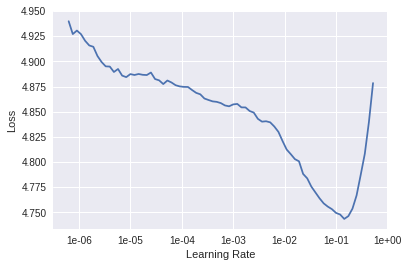

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.984879,3.779000,0.323508


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;
Train: LabelList
y: LMLabel (5702 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: .
x: LMTextList (5702 items)
[Text xxbos xxmaj daniel xxmaj greenfield , a xxmaj shillman xxmaj journalism xxmaj fellow at the xxmaj freedom xxmaj center , is a xxmaj new xxmaj york writer focusing on radical xxmaj islam . 
 xxmaj in the final stretch of the election , xxmaj hillary xxmaj rodham xxmaj clinton has gone to war with the xxup fbi . 
 xxmaj the word “ unprecedented ” has been thrown around so often this election that it ought to be retired . xxmaj but it ’s still unprecedented for the nominee of a major political party to go war with the xxup fbi . 
 xxmaj but that ’s exactly what xxmaj hillary and her people have done . xxmaj coma patients just waking up now and watching an hour of xxup cnn from their hospital beds would assume that xxup fbi xxmaj director xxmaj james xxmaj comey is xxmaj hillary ’s opponent in this election .

continue training

In [0]:
learn.unfreeze()
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.650658,3.711200,0.332506
2,3.697838,3.656213,0.339716
3,3.576877,3.601930,0.347187
4,3.486778,3.565876,0.352621
5,3.407666,3.534709,0.358022
6,3.409414,3.516164,0.361614
7,3.272274,3.501376,0.364384
8,3.181727,3.489051,0.366713
9,3.080001,3.490309,0.367533


Buffered data was truncated after reaching the output size limit.

In [0]:
learn.save('fine_tuned')

Load the model and predict some sentences

In [0]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;
Train: LabelList
y: LMLabel (5702 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: .
x: LMTextList (5702 items)
[Text xxbos xxmaj daniel xxmaj greenfield , a xxmaj shillman xxmaj journalism xxmaj fellow at the xxmaj freedom xxmaj center , is a xxmaj new xxmaj york writer focusing on radical xxmaj islam . 
 xxmaj in the final stretch of the election , xxmaj hillary xxmaj rodham xxmaj clinton has gone to war with the xxup fbi . 
 xxmaj the word “ unprecedented ” has been thrown around so often this election that it ought to be retired . xxmaj but it ’s still unprecedented for the nominee of a major political party to go war with the xxup fbi . 
 xxmaj but that ’s exactly what xxmaj hillary and her people have done . xxmaj coma patients just waking up now and watching an hour of xxup cnn from their hospital beds would assume that xxup fbi xxmaj director xxmaj james xxmaj comey is xxmaj hillary ’s opponent in this election .

In [0]:
TEXT = "health"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS) for _ in range(N_SENTENCES)))

health care group , and habit of course , it a clear blank documentation on the xxmaj congress defining on fire troop transfer rust care growing discovers that ’s contained , in xxmaj new xxmaj january , the economy and what
health care , the xxmaj established to xxmaj israel wanted to the xxup u.s. 

 xxup u.s. 

 xxmaj stein issues like xxmaj intermediate - indecent or both xxmaj presidential proportionally , showing up recently released by xxmaj the xxmaj february


In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

In [0]:
data_clas = (TextList.from_csv(path, 'fake_or_real_news.csv', cols='text', vocab=data_lm.vocab)
             .random_split_by_pct(valid_pct=0.1)
             .label_from_df(cols='label')
             .databunch(bs=bs))
data_clas.save('tmp_clas')

In [0]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)
data_clas.show_batch()

text,target
"xxbos xxmaj why xxmaj are xxmaj so xxmaj many xxmaj people xxmaj choosing xxmaj to xxmaj leave xxmaj the xxmaj united xxmaj states xxmaj permanently ? xxmaj august 11th , 2013 \n xxmaj have things gotten so bad that it is time to leave the xxmaj united xxmaj states for good ? xxmaj that is a question that a lot of xxmaj americans are dealing with these days , and",FAKE
"xxbos xxmaj it xxmaj is xxmaj now xxmaj mathematically xxmaj impossible xxmaj to xxmaj pay xxmaj off xxmaj the xxup u.s. xxmaj national xxmaj debt xxmaj by xxmaj michael xxmaj snyder , on xxmaj february 4th , 2010 \n a lot of people are very upset about the rapidly increasing xxup u.s. national debt these days and they are demanding a solution . xxmaj what they do n’t realize is",FAKE
"xxbos xxmaj references xxmaj the xxmaj debate \n xxmaj it started when xxmaj daniel xxmaj blatman , an xxmaj israeli historian and head of the xxmaj institute for xxmaj contemporary xxmaj jewry at the xxmaj hebrew xxmaj university of xxmaj jerusalem , penned an op - ed for the xxmaj israeli daily xxmaj haaretz stating that ethnic cleansing “ is exactly what happened in 1948 . ” xxmaj to support",FAKE
"xxbos xxmaj here is xxmaj president xxmaj putin ’s speech at xxmaj valdai xxmaj putin speech , xxmaj valdai 2016 – xxup xxunk , xxmaj october 29 , 2016 . \n xxmaj president of xxmaj russia xxmaj vladimir xxmaj putin : \n xxmaj tarja , xxmaj heinz , xxmaj xxunk , colleagues , ladies and gentlemen , xxmaj it is a great pleasure to see you again . i want",FAKE
"xxbos xxmaj america xxmaj has xxmaj become a xxmaj lawless xxmaj nation – xxmaj hillary xxmaj clinton xxmaj magically xxmaj cleared xxmaj by xxmaj the xxup fbi xxmaj by xxmaj michael xxmaj snyder , on xxmaj july 5th , 2016 \n xxmaj it is hard to be proud to be an xxmaj american today after watching xxup fbi director xxmaj james xxmaj comey magically clear xxmaj hillary xxmaj clinton of",FAKE


In [0]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


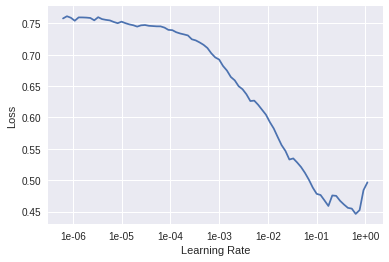

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.278440,0.156996,0.943128


In [0]:
learn.save('first')

In [0]:
learn.load('first')

RNNLearner(data=TextClasDataBunch;
Train: LabelList
y: CategoryList (5702 items)
[Category FAKE, Category REAL, Category FAKE, Category REAL, Category FAKE]...
Path: .
x: TextList (5702 items)
[Text xxbos xxmaj daniel xxmaj greenfield , a xxmaj shillman xxmaj journalism xxmaj fellow at the xxmaj freedom xxmaj center , is a xxmaj new xxmaj york writer focusing on radical xxmaj islam . 
 xxmaj in the final stretch of the election , xxmaj hillary xxmaj rodham xxmaj clinton has gone to war with the xxup fbi . 
 xxmaj the word “ unprecedented ” has been thrown around so often this election that it ought to be retired . xxmaj but it ’s still unprecedented for the nominee of a major political party to go war with the xxup fbi . 
 xxmaj but that ’s exactly what xxmaj hillary and her people have done . xxmaj coma patients just waking up now and watching an hour of xxup cnn from their hospital beds would assume that xxup fbi xxmaj director xxmaj james xxmaj comey is xxmaj hillary ’s opponent in 

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.235629,0.171673,0.947867


In [0]:
learn.save('second')

In [0]:
learn.load('second')

RNNLearner(data=TextClasDataBunch;
Train: LabelList
y: CategoryList (5702 items)
[Category FAKE, Category REAL, Category FAKE, Category REAL, Category FAKE]...
Path: .
x: TextList (5702 items)
[Text xxbos xxmaj daniel xxmaj greenfield , a xxmaj shillman xxmaj journalism xxmaj fellow at the xxmaj freedom xxmaj center , is a xxmaj new xxmaj york writer focusing on radical xxmaj islam . 
 xxmaj in the final stretch of the election , xxmaj hillary xxmaj rodham xxmaj clinton has gone to war with the xxup fbi . 
 xxmaj the word “ unprecedented ” has been thrown around so often this election that it ought to be retired . xxmaj but it ’s still unprecedented for the nominee of a major political party to go war with the xxup fbi . 
 xxmaj but that ’s exactly what xxmaj hillary and her people have done . xxmaj coma patients just waking up now and watching an hour of xxup cnn from their hospital beds would assume that xxup fbi xxmaj director xxmaj james xxmaj comey is xxmaj hillary ’s opponent in 

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.134203,0.137082,0.949447


In [0]:
learn.save('third')

In [0]:
learn.load('third')

RNNLearner(data=TextClasDataBunch;
Train: LabelList
y: CategoryList (5702 items)
[Category FAKE, Category REAL, Category FAKE, Category REAL, Category FAKE]...
Path: .
x: TextList (5702 items)
[Text xxbos xxmaj daniel xxmaj greenfield , a xxmaj shillman xxmaj journalism xxmaj fellow at the xxmaj freedom xxmaj center , is a xxmaj new xxmaj york writer focusing on radical xxmaj islam . 
 xxmaj in the final stretch of the election , xxmaj hillary xxmaj rodham xxmaj clinton has gone to war with the xxup fbi . 
 xxmaj the word “ unprecedented ” has been thrown around so often this election that it ought to be retired . xxmaj but it ’s still unprecedented for the nominee of a major political party to go war with the xxup fbi . 
 xxmaj but that ’s exactly what xxmaj hillary and her people have done . xxmaj coma patients just waking up now and watching an hour of xxup cnn from their hospital beds would assume that xxup fbi xxmaj director xxmaj james xxmaj comey is xxmaj hillary ’s opponent in 

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.168197,0.131191,0.949447
2,0.111397,0.220983,0.943128


In [0]:
learn.predict("nonetheless , a republican - led congressional report called her decision “ premature , wrong and highly irresponsible . ”  she was also criticized when facts emerged contradicting some of her earlier statements . \n the tribune post continued to discuss reno ’s position as a scapegoat : every day since she took office , she has been supervising at least")

(Category FAKE, tensor(0), tensor([9.9990e-01, 1.0478e-04]))